## Pendulum: Two-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import *
from data_loader import *

In [3]:
model = 'pendulum'

1. This u will be drawn from a GP and in order to generate a test set we again draw from the same GP with another bandwidth and scaled to represent a small perturbation. 
2. We still have the access to the derivatives. Check how derivatives are computed. 
3. Draw from a GP and add those value to the sine. 

### Solution: Two-Step Method

> Step 1: Learning $u's$

In [4]:
optim_sgm, alphas, optim_lmbd = kernel_parameters(x_train.reshape(-1,1),u_train,e)

In [5]:
optim_sgm, optim_lmbd 

(array([0.14840741, 0.88888889, 0.88888889]),
 array([4.28133240e-14, 6.95192796e-12, 6.95192796e-12]))

In [6]:
u_pred_train, u_x_pred_train, u_xx_pred_train = predictions_ode(x_train, x_train, Gaussian, optim_sgm, alphas,e)
#u_pred_test,  u_x_pred_test,  u_xx_pred_test  = predictions_ode(x_test,  x_train, Gaussian, optim_sgm, alphas)

In [7]:
# Save true values to warm up the onepfive method
np.save('data/u_pred_train.npy', u_pred_train)
# Save true gradients for comparing later
np.save('data/u_x_train.npy',u_x_train)
np.save('data/u_xx_train.npy',u_xx_train)
# Save gradients for one step method
np.save('data/u_x_pred_train.npy',u_x_pred_train)
np.save('data/u_xx_pred_train.npy',u_xx_pred_train)

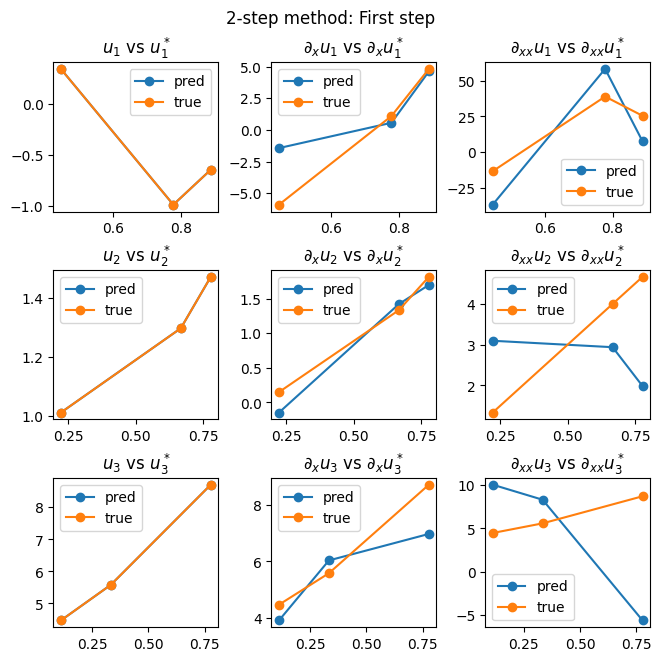

In [8]:
fig, axs = plt.subplots(nrows = 3, ncols=3 , figsize = (6.5,6.5),constrained_layout=True)
fig.suptitle('2-step method: First step')
axs[0, 0].plot(x_train[:e], u_pred_train[:,0],marker= 'o', label = 'pred')
axs[0, 0].plot(x_train[:e], u_train[:,0],marker= 'o', label = 'true')
axs[0, 0].legend()
axs[0, 0].set_title('$u_1$ vs $u_1^*$')
axs[0, 1].plot(x_train[:e], u_x_pred_train[:,0],marker= 'o', label = 'pred')
axs[0, 1].plot(x_train[:e], u_x_train[:,0],marker= 'o', label = 'true')
axs[0, 1].legend()
axs[0, 1].set_title('$\partial_x u_1$ vs $\partial_x u_1^*$')
axs[0, 2].plot(x_train[:e], u_xx_pred_train[:,0],marker= 'o', label = 'pred')
axs[0, 2].plot(x_train[:e], u_xx_train[:,0],marker= 'o', label = 'true')
axs[0, 2].legend()
axs[0, 2].set_title('$\partial_{xx} u_1$ vs $\partial_{xx} u_1^*$')
axs[1, 0].plot(x_train[e:2*e], u_pred_train[:,1],marker= 'o', label = 'pred')
axs[1, 0].plot(x_train[e:2*e], u_train[:,1],marker= 'o', label = 'true')
axs[1, 0].legend()
axs[1, 0].set_title('$u_2$ vs $u_2^*$')
axs[1, 1].plot(x_train[e:2*e], u_x_pred_train[:,1],marker= 'o', label = 'pred')
axs[1, 1].plot(x_train[e:2*e], u_x_train[:,1],marker= 'o', label = 'true')
axs[1, 1].legend()
axs[1, 1].set_title('$\partial_x u_2$ vs $\partial_x u_2^*$')
axs[1, 2].plot(x_train[e:2*e], u_xx_pred_train[:,1],marker= 'o', label = 'pred')
axs[1, 2].plot(x_train[e:2*e], u_xx_train[:,1],marker= 'o', label = 'true')
axs[1, 2].legend()
axs[1, 2].set_title('$\partial_{xx} u_2$ vs $\partial_{xx} u_2^*$')
axs[2, 0].plot(x_train[2*e:3*e], u_pred_train[:,2],marker= 'o', label = 'pred')
axs[2, 0].plot(x_train[2*e:3*e], u_train[:,2],marker= 'o', label = 'true')
axs[2, 0].legend()
axs[2, 0].set_title('$u_3$ vs $u_3^*$')
axs[2, 1].plot(x_train[2*e:3*e], u_x_pred_train[:,2],marker= 'o', label = 'pred')
axs[2, 1].plot(x_train[2*e:3*e], u_x_train[:,2],marker= 'o', label = 'true')
axs[2, 1].legend()
axs[2, 1].set_title('$\partial_x u_3$ vs $\partial_x u_3^*$')
axs[2, 2].plot(x_train[2*e:3*e], u_xx_pred_train[:,2],marker= 'o', label = 'pred')
axs[2, 2].plot(x_train[2*e:3*e], u_xx_train[:,2],marker= 'o', label = 'true')
axs[2, 2].legend()
axs[2, 2].set_title('$\partial_{xx} u_3$ vs $\partial_{xx} u_3^*$')
fig.show()

Let's compute the RKHSs norms of each $u_i$

In [9]:
rkhss = []
for i in range(3):
    G = K(Gaussian,x_train[e*i:e*(i+1)],x_train[e*i:e*(i+1)],optim_sgm[i])
    alphas = np.linalg.solve(G, u_pred_train[:,i])
    rkhss.append(np.sqrt(np.dot(u_pred_train[:,i],alphas)))

In [10]:
rkhss

[1.0878018748947793, 3.180451099204698, 11.67100972299891]

> Step 2: Learning $P$

In [11]:
s_train = np.hstack((x_train_all.reshape(-1,1),u_pred_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1),u_xx_pred_train.T.reshape(-1,1)))  # 30 * 4
f_train = f_Train(model)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)

In [12]:
optim_sgm_P, optim_lmbd_P = grid_search_RBF(s_train_s,f_train)
krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_lmbd_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 

In [13]:
optim_sgm_P, optim_lmbd_P

(0.8152746744832159, 1.8329807108324374e-13)

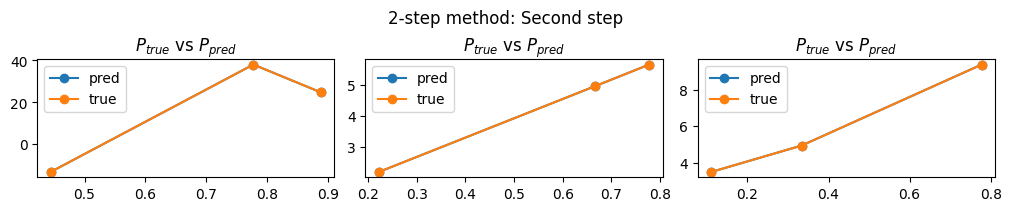

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols=3 , figsize = (10, 2),constrained_layout=True)
fig.suptitle('2-step method: Second step')
axs[0].plot(x_train[:e], f_pred_train[:e], marker= 'o', label = 'pred')
axs[0].plot(x_train[:e], f_train[:e] , marker= 'o', label = 'true')
axs[0].legend()
axs[0].set_title('$P_{true}$ vs $P_{pred}$')
axs[1].plot(x_train[e:2*e], f_pred_train[e:2*e],marker= 'o', label = 'pred')
axs[1].plot(x_train[e:2*e], f_train[e:2*e],marker= 'o', label = 'true')
axs[1].legend()
axs[1].set_title('$P_{true}$ vs $P_{pred}$')
axs[2].plot(x_train[2*e:3*e], f_pred_train[2*e:3*e],marker= 'o', label = 'pred')
axs[2].plot(x_train[2*e:3*e], f_train[2*e:3*e],marker= 'o', label = 'true')
axs[2].legend()
axs[2].set_title('$P_{true}$ vs $P_{pred}$')
fig.show()

Let's calculate the RKHS norm of the predicted operator

In [26]:
G = K(Gaussian,s_train_s,s_train_s, optim_sgm_P) + 1e-7*np.eye(x_train.size) # added nugget here !
alphas_P = np.linalg.solve(G, f_pred_train)
rkhs_P = np.sqrt(np.dot(f_pred_train,alphas_P))

In [27]:
rkhs_P

63.55198060496819

**Testing**: We recreate three scenarios. All of them are passing the sanity check that if we add noise 0 we should get a small mse. 

Also, we have two types of experiments:
1. we add the noise and then rescale the perturbed data
2. we just apply noise directly to the scaled data

>Test 1: Add arbitrary noise to observations.

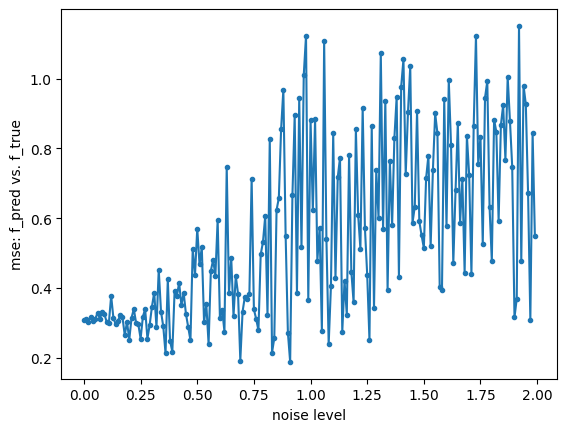

In [17]:
scales = np.arange(0.0,2,0.01)   
mses_P = [] 
for scale in scales:
    # Perturb 
    s_test = np.random.normal(s_train,scale=scale)
    # Scale 
    s_test_s = scaler_s_train.transform(s_test)
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot 
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [18]:
# Perturb  
s_test = np.random.normal(s_train,scale=0.0)
# Scale 
s_test_s = scaler_s_train.transform(s_test) 
# Compute predictions on test 
f_pred_test = krr_optimal_P.predict(s_test_s) 
# True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
f_true_test = f_true_Test(model, s_test) 

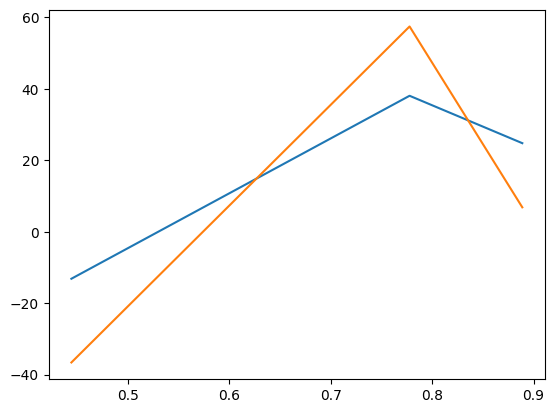

In [19]:
plt.plot(x_train[:e],f_pred_test[:e])
plt.plot(x_train[:e],f_true_test[:e])

> Test 2: Compute global std $\sigma_{\text{global}}$ of `s_train_s` and perturb directly `s_train_s` using $m \sigma_{\text{global}}$ each element. $m \in (0.00,0.25)$.

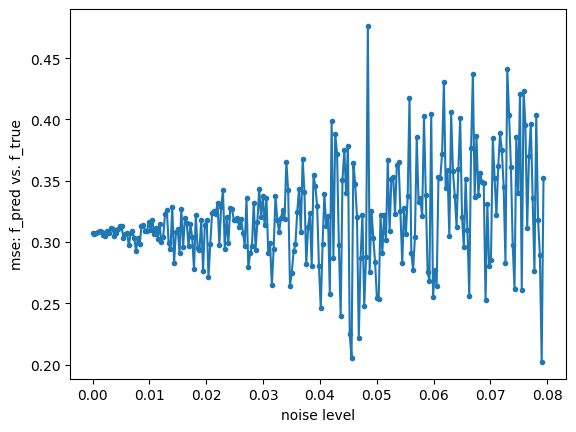

In [20]:
# Compute global std of s_train_s
global_std = np.std(s_train_s)

scales = np.arange(0.0,0.25,0.001)*global_std   
mses_P = [] 
for scale in scales:
    # Perturb scaled training data
    s_test_s = np.random.normal(s_train_s,scale=scale)
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    s_test = scaler_s_train.inverse_transform(s_test_s)
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot 
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

> Test 3: Compute std per feature i $\sigma_{\text{s[:,i]}}$ of `s_train_s` and perturb feature i of `s_train_s` using $m \sigma_{\text{s[:,i]}}$ each element. $m \in (0.01,0.25)$.

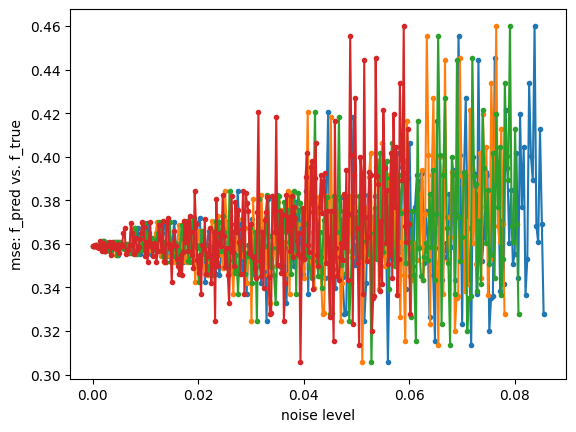

In [21]:
# Compute std per feature of s_train_s
stds = np.std(s_train_s, axis = 0)

scales = np.outer(np.arange(0.0,0.25,0.001),stds)
mses_P = [] 
for i in range(len(scales)):
    # Scales for current iteration
    scale = scales[i,:]
    # Perturb each feature
    for j in range(4):
        s_test_s[:,j] = np.random.normal(s_train_s[:,j] , scale = scale[j])
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()